In [17]:
import sys
!conda install --yes --prefix {sys.prefix} pandas
!conda install --yes --prefix {sys.prefix} matplotlib
!conda install --yes --prefix {sys.prefix} opencv
!conda install --yes --prefix {sys.prefix} scipy

Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done
Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done
Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done
Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done


# Import Reference

Import modules and reference information of the images

In [1]:
import numpy as np
import cv2
from operator import itemgetter
import glob
import matplotlib.pyplot as plt
import os

# ...load files in a folder
from PIL import Image
# path = input('Enter folder path:')
path = os.path.abspath(os.getcwd())
image_list = np.genfromtxt(path+"\Reference\Reference.csv", dtype=None, delimiter=',', skip_header=0, names=True, encoding=None)


# Import images

Generic Functions

In [12]:
# Get rotation angles from the reference file
def getrot(image_list, image_name):
    rot = ['rolldeg', 'pitchdeg', 'headingdeg']
    r_xx, r_yy, r_zz = itemgetter(*rot)(image_list[image_list['file_name']==image_name])         # in degrees
    r_xx = float(r_xx)                                                                           # just because the roll angle is read as a double when read from ref file
    r_yy = float(r_yy)
    r_zz = float(r_zz)
    return r_xx, r_yy, r_zz

# Rolling Rotation Transformation
def rollrot(rot_angle, cols, rows, img_mat):
    # Determine the centre of rotation
    if rot_angle<0:
        rot_centre = (cols,0)
    else:
        rot_centre = (0,0)
    # Do rotation
    rot_mat = cv2.getRotationMatrix2D(rot_centre, rot_angle, 1.0)
    new_img = cv2.warpAffine(img_mat, rot_mat, (cols,rows), flags=cv2.INTER_LINEAR)
    return new_img

# Crop black-out pixels from image for saving
def crop(img_mat):
    crop_area = np.nonzero(img_mat)
    x_min = min(crop_area[1])
    x_max = max(crop_area[1])
    y_min = min(crop_area[0])
    y_max = max(crop_area[0])
    new_img = img_mat[y_min:y_max, x_min:x_max] 
    return new_img


## Method 1 - Homography H = kRk'X (failed)

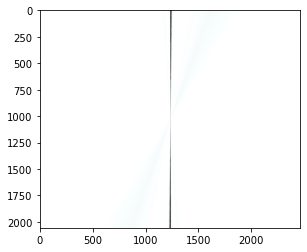

In [83]:
from scipy.spatial.transform import Rotation as R

for filename in glob.iglob(path+'/Input'+'/*.jpg'):                  # keeping this because you can choose to process a small portion of images in a large reg sheet
    # Open the path and save the image_name
    os.chdir(path)
    image_name = os.path.basename(filename) 
    img = cv2.imread(filename)
    rows,cols,ch = img.shape
    
    # Assemble rotation matrix from reference file
    rot = ['rolldeg', 'pitchdeg', 'headingdeg']
    r_xx, r_yy, r_zz = itemgetter(*rot)(image_list[image_list['file_name']==image_name])         # in degrees
    # r_xx = image_list[image_list['file_name']==image_name]['rolldeg'] * -1         # in degrees
    r_xx = float(r_xx)                                                               # just because the roll angle is read as a double when read from ref file
    r_yy = float(r_yy)
    # r_zz = float(r_zz)
    r_zz = 0
    
    # Projection matrix
    A1 = [[1.0, 0.0, -cols/2],
          [0.0, 1.0, -rows/2],
          [0.0, 0.0, 0.0],
          [0.0, 0.0, 1.0]]
    
    # Get rotation matrix
    r1 = R.from_euler('xyz',[r_xx, 0, 0], degrees=True).as_matrix()
    r2 = R.from_euler('xyz',[0,r_yy,0], degrees=True).as_matrix()
    r3 = R.from_euler('xyz',[0,0,r_zz], degrees=True).as_matrix()
    
    R = np.matmul(r1,np.matmul(r2,r3))
    R = np.hstack((np.vstack((R,[0,0,0])),np.array([0,0,0,1]).reshape(4,1)))           # Transforming 3x3 rotation matrix into 4x4
    
    # Get translation matrix
    H = 1.812                                                                          # height of camera to ground (m) - calculated from z_image csv - z_point cloud
    T = np.identity(4)
    dist = -H / np.tan(np.abs(np.deg2rad(r_yy)))
    T[2,3] = dist

    
    # K - intrinsic matrix
    f = 8.5e-3                                                                       # MX9 brochure for focal length (m) of pavement camera
    # cx = 0.231849365                                                                 # From CIT lab project
    # cy = 0
    cx = 1/0.00345
    cy = 0
    K = np.array([[f,0,cols/2,0],
          [0,f,rows/2,0],
          [0,0,1,0]])
    # K2 = np.array([[f,0,cx,0],
    #       [0,f,cy,0],
    #       [0,0,1,0]])
    # K1 = np.array([[1/f,0,-cx/f],
    #       [0,1/f,-cy/f],
    #       [0,0,0],
    #       [0,0,1]])
#     # K1 = [[-1.0, 0.0, 0.0, 0.231849365],
#     #      [0.0, 1.0, 0.0, 0.0],
#     #      [0.0, 0.0, -1.0, -0.400589653],
#     #      [0.0, 0.0, 0.0, 1.0]]
#     # K2 = np.linalg.inv(K1)
    
    M = np.matmul(K,np.matmul(T,np.matmul(R,A1)))


#     H1 = np.matmul(K1,R)
#     # H = np.matmul(H1,T)
#     # M = np.matmul(K2,H)
#     print(H1, '\n',T, '\n',H1)
#     # print(M)
    
#     # M_fwd = R.from_euler('zyx',[r_zz,r_yy,r_xx], degrees=True)
#     # M = M_fwd.inv().as_matrix()
#     # M = M/M[0][0]
#     # print(M)
#     # waM = np.array([[1,1,0],[0,1.9202,0],[0,1.72e-3,1]])
    
    # Try warping transformation with the rotation matrix
    new_img = cv2.warpPerspective(img,M,(cols,rows))
    plt.imshow(new_img)
    #print(new_img)
    
#     # Save in new directory
#     # Change the current directory to specified directory 
#     os.chdir(path+'/Results/')
#     newfile = image_name.split('.jpg')[0] + '_2.jpg'
#     cv2.imwrite(newfile, new_img)

## Method 2 - Geometric Transforms

Reference in https://stackoverflow.com/questions/17087446/how-to-calculate-perspective-transform-for-opencv-from-rotation-angles

Module perspective cloned from https://github.com/manisoftwartist/perspectiveproj.git

In [14]:
from scipy.spatial.transform import Rotation as R
import perspective as per
M = []

for filename in glob.iglob(path+'/Input'+'/*.jpg'):                  # keeping this because you can choose to process a small portion of images in a large reg sheet
    # Open the path and save the image_name
    os.chdir(path)
    image_name = os.path.basename(filename) 
    img = cv2.imread(filename)
    rows,cols,ch = img.shape
    
    # Get rotation angles from reference file
    r_theta, r_phi, r_yaw = getrot(image_list,image_name)
    
#     # Get rotation matrix
#     r1 = R.from_euler('zyx',[r_theta, 0, 0], degrees=True).as_matrix()
#     r2 = R.from_euler('zyx',[0,0,r_phi], degrees=True).as_matrix()
#     r3 = R.from_euler('zyx',[0,0,r_yaw], degrees=True).as_matrix()
#     R = np.array(r3 * r2 * r1)
    
    # # Guess the right orientation
    # phi = np.array([-180,-135,-90,-45,0,45,90,135,180])
    # phi = phi + r_phi
    # fv = [-135,-90,-45,0.1,45,90,135]
    # # phi = [-(90+r_phi)]
    # # fv = [2*abs(phi[0]),120,135,150,165]
    # fig = plt.figure(figsize=(50, 50))
    # grid = plt.GridSpec(len(fv), len(phi), figure=fig)
    # for j, fvi in enumerate(fv):
    #     for i, value in enumerate(list(phi)):
    #         imgwarped = per.warpImage(img,-r_theta,value, 0, 1, fvi)
    #         # plot_id = plot_max *100 + 50 + (j*5+i+1)
    #         exec(f"plt.subplot(grid{[j*len(phi)+i]})")
    #         plt.imshow(imgwarped), plt.title('phi={:.2f}, fv={:.2f}'.format(value, fvi))
    # plt.show()
    # plt.savefig('plots.png',dpi=150)
    
    # Transform Image
    # Inputs: def warpImage(src,theta, phi,gamma,scale,fovy,corners=None)
    # FoV = Horizontal 82.9, Vertical 65.9 degrees on MX9 brochure. So FoV = 165 degrees is a right guess
    imgwarped = per.warpImage(img,-r_theta,-(90+r_phi), 0, 1, 165)
    
#     # Scale x2 for trial
#     imgwarped2 = per.warpImage(img,-r_theta,-(90+r_phi), 0, 2, 165)

#     plt.subplot(121), plt.imshow(imgwarped), plt.title('Scale = 1')
#     plt.subplot(122), plt.imshow(imgwarped2), plt.title('Scale = 2')
#     plt.show()
    
    # # Get rotation matrix
    # M_new,sl      = per.warpMatrix(cols,rows, -r_theta,-(90+r_phi),0, 1, 165)
    # M.append(M_new)

    # Crop image for saving
    new_img = crop(imgwarped)

    
    # Save in new directory
    # Change the current directory to specified directory 
    os.chdir(path+'/Results/')
    newfile = image_name.split('.jpg')[0] + '_2.jpg'
    cv2.imwrite(newfile, new_img)

# np.savetxt("Matrix.csv", M, delimiter=",")

Output image dimension = 24586


## Method 3 - Geometric Transform (2)
Idea follow Bertozzi et al. (1997) Stereo inverse perspective mapping: theory and applications

Implementation inspired by Kong et al. (2022) Automatic Detection and Assessment of Pavement Marking Defects with Street View Imagery at the City Scale

Unhide the prototype to experiment on the formulae or different input angles.

[[ 2.20554090e+00  3.30166328e+01 -3.42098647e+01]
 [ 1.29563453e-03  3.74268463e+01 -3.64158330e+01]
 [-3.82301170e-10  1.23090056e-02  1.00000000e+00]]


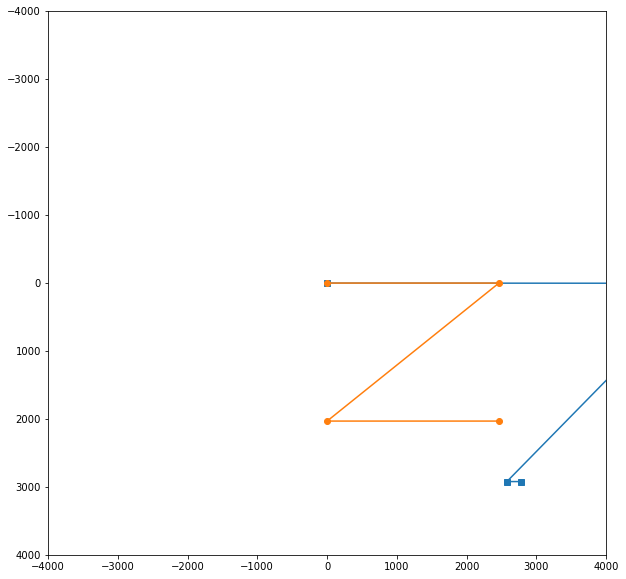

In [8]:
# Prototype

l = 0
d = 0
h = 1.812
gamma = 0
# theta = r_phi
theta = -40.3008
# follow Trimble datasheet
alpha = 82.9/2
beta = 65.9/2
# m, n = cols, rows
m = 2464   # width
n = 2032   # height
pos = [[1,1],[2464,1],[1,2032],[2464,2032]]        # (u_i, v_i), in the order of ABCD, origin at top left hand corner
# u = 1
# v = 2032

r_gamma, r_theta, r_alpha, r_beta = np.abs(np.deg2rad([gamma, np.abs(theta), alpha, beta]))

# My interpretation of Bertozzi (1997)
# x = h * 1/np.tan((r_theta-r_beta)+ u*2*r_beta/(n-1)) * np.cos((r_gamma-r_alpha)+v*2*r_alpha/(n-1)) + l
# y = h * 1/np.tan((r_theta-r_beta)+ u*2*r_beta/(n-1)) * np.sin((r_gamma-r_alpha)+v*2*r_alpha/(n-1)) + d

# equation in https://blog.csdn.net/feiyang_luo/article/details/103555036
# x = h * 1/np.tan((r_theta-r_alpha)+ u*2*r_alpha/(n-1)) * np.sin((r_gamma-r_alpha)+v*2*r_alpha/(n-1)) + l
# y = h * 1/np.tan((r_theta-r_alpha)+ u*2*r_alpha/(n-1)) * np.cos((r_gamma-r_alpha)+v*2*r_alpha/(n-1)) + d

pos_trans = []
for i, item in enumerate(pos):
    u = item[0]
    v = item[1]
    x = h * 1/np.tan(r_theta-r_beta+ 2*r_beta*v/(n-1)) * np.cos(-r_gamma-r_alpha+2*r_alpha*u/(m-1)) + l
    y = h * 1/np.tan(r_theta-r_beta+ 2*r_beta*v/(n-1)) * np.sin(-r_gamma-r_alpha+2*r_alpha*u/(m-1)) + d
    # x = h * 1/np.tan((r_theta-r_alpha)+ v*2*r_alpha/(n-1)) * np.sin((r_gamma-r_beta)+u*2*r_beta/(m-1)) + d
    # y = h * 1/np.tan((r_theta-r_alpha)+ v*2*r_alpha/(n-1)) * np.cos((r_gamma-r_beta)+u*2*r_beta/(m-1)) + l
    psm = 1/0.00345
    pos_trans.append([x*psm,y*psm])
    
new_pos = pos_trans

# # flipped transformed points along the y-axis
# # centred at A, add distance AB in x-direction. Don't touch the y-direction
# for i,item in enumerate(new_pos):
#     if i==0: continue
#     else:
#         dist = np.abs(new_pos[0][0]-item[0])
#         new_pos[i][0] = new_pos[0][0] + dist


# Rotation by 90 degrees
pos_trans_rot = np.transpose(np.vstack((np.array([item[0] for item in new_pos]),np.array([item[1] for item in new_pos]))))
clockwise = True
if clockwise == True:
    rot = np.array([[0, -1],
                    [1, 0]])
elif clockwise == False:
    rot = np.array([[0, 1],
                    [-1, 0]])
new_pos = (np.matmul(pos_trans_rot, rot))

# move transformed to origin
dist_x, dist_y = new_pos[0][0]-pos[0][0], new_pos[0][1]-pos[0][1]
new_pos = new_pos - np.array([dist_x, dist_y])

# Check transformation matrix
pos = np.float32(pos)
new_pos = np.float32(new_pos)
H = cv2.getPerspectiveTransform(pos, new_pos)
print(H)

plt.figure(figsize=(10, 10))
plt.plot([item[0] for item in new_pos],[item[1] for item in new_pos],marker='s')
# plt.plot(new_pos[:,0],new_pos[:,1],marker='s')
plt.plot([item[0] for item in pos],[item[1] for item in pos],marker='o')
# plot.autoscale()
plt.xlim(-4000, 4000)
plt.ylim(-4000, 4000)
plt.gca().invert_yaxis()
plt.show()

# temp = np.arctan((y-d)/(x-l))
# if temp == 0:
#     temp = 1e-10
# u_ortho = (np.arctan(h*np.sin(temp)/(y-d)) - (r_theta - r_alpha))/(2*r_alpha/(n-1))
# # v_ortho = (temp - (r_gamma - r_alpha))/(2*r_alpha/(n-1))
# v_ortho = (temp - (r_gamma - r_beta))/(2*r_beta/(m-1))

# # u_ortho = (np.arctan((x-d)/(y-l)) - (r_gamma - r_alpha))/(2*r_alpha/(n-1))
# # v_ortho = (np.arctan(h/np.sqrt((x-d)**2+(y-l)**2))-(r_theta-r_beta))/(2*r_beta/(m-1))

# print(u_ortho, v_ortho)

In [5]:
# Function of the prototype above
def BertozziTrans(r_phi, cols, rows):
    # camera movement and position
    l = 0
    d = 0
    h = 1.812                                      # measured from z in pavement image csv to z in point cloud
    # image rotations
    gamma = 0                                      # forget about yawing rotation until the modelling stage
    theta = r_phi                                  # pitch 
    # field of view - follow Trimble datasheet
    alpha = 82.9/2
    beta = 65.9/2
    # m - width, n - height of image
    m = cols   # width
    n = rows   # height
    pos = [[1,1],[cols,1],[1,rows],[cols,rows]]        # (u_i, v_i), in the order of ABCD, origin at top left hand corner

    r_gamma, r_theta, r_alpha, r_beta = np.abs(np.deg2rad([gamma, np.abs(theta), alpha, beta]))

    pos_trans = []
    for i, item in enumerate(pos):
        u = item[0]
        v = item[1]
        x = h * 1/np.tan(r_theta-r_beta+ 2*r_beta*v/(n-1)) * np.cos(-r_gamma-r_alpha+2*r_alpha*u/(m-1)) + l
        y = h * 1/np.tan(r_theta-r_beta+ 2*r_beta*v/(n-1)) * np.sin(-r_gamma-r_alpha+2*r_alpha*u/(m-1)) + d
        psm = 1/0.00345                                # pixels per meter, follow Trimble datasheet
        pos_trans.append([x*psm,y*psm])
    
    new_pos = pos_trans

    # # flipped transformed points along the y-axis
    # # centred at A, add distance AB in x-direction. Don't touch the y-direction
    # for i,item in enumerate(new_pos):
    #     if i==0: continue
    #     else:
    #         dist = np.abs(new_pos[0][0]-item[0])
    #         new_pos[i][0] = new_pos[0][0] + dist


    # Rotation by 90 degrees
    pos_trans_rot = np.transpose(np.vstack((np.array([item[0] for item in new_pos]),np.array([item[1] for item in new_pos]))))
    clockwise = True
    if clockwise == True:
        rot = np.array([[0, -1],
                        [1, 0]])
    elif clockwise == False:
        rot = np.array([[0, 1],
                        [-1, 0]])
    new_pos = (np.matmul(pos_trans_rot, rot))

    # move transformed to origin
    dist_x, dist_y = new_pos[0][0]-pos[0][0], new_pos[0][1]-pos[0][1]
    new_pos = new_pos - np.array([dist_x, dist_y])
    
    # Check transformation matrix
    pos = np.float32(pos)
    new_pos = np.float32(new_pos)
    H = cv2.getPerspectiveTransform(pos, new_pos)
    
    return H


In [13]:
# Implementation

for filename in glob.iglob(path+'/Input'+'/*.jpg'):                  # keeping this because you can choose to process a small portion of images in a large reg sheet
    # Open the path and save the image_name
    os.chdir(path)
    image_name = os.path.basename(filename) 
    img = cv2.imread(filename)
    rows,cols,ch = img.shape

    r_xx, r_yy, r_zz = getrot(image_list, image_name)

    M = BertozziTrans(r_yy, cols, rows)
    new_img = cv2.warpPerspective(img,M,(10000,10000))          # say max image size 10000x10000. To be cropped in the next step
   
    new_img = rollrot(-r_xx, 10000, 10000, new_img)              # do rolling rotation first
    new_img = crop(new_img)
    
    
    # Save in new directory
    # Change the current directory to specified directory 
    os.chdir(path+'/Results/')
    newfile = image_name.split('.jpg')[0] + '_2.jpg'
    cv2.imwrite(newfile, new_img)

## Method 4 - The hard-coded method

In [92]:
# Past code in .py
# hard-coded the 4 target dst corners

# Destinations of coordinates
if (rows,cols) == (2056,2464):
    # images of 2464 x 2056
    # From coordinates that you want to do perspective transform
    pts1 = np.float32([[0,0],[2464,0],[0,2056],[2464,2056]])
    # To desired coordinates
    pts2 = np.float32([[0,0],[2464,0],[787,1426],[1677,1426]])
    new_rows = 1426
elif (rows,cols) == (1028,1232):
    # From coordinates
    pts1 = np.float32([[0,0],[1232,0],[0,1028],[1232,1028]])
    # To desired coordinates
    pts2 = np.float32([[0,0],[1232,0],[394,713],[839,713]])
    new_rows = 713
else:
    continue

# get transformation matrix
M = cv2.getPerspectiveTransform(pts1,pts2)
# do warping
new_img = cv2.warpPerspective(img,M,(cols,rows))

# Rotation
# ... read rotation degrees from the excel sheet
rot_angle = image_list[image_list['file_name']==image_name]['rolldeg'] * -1         # in degrees
rot_angle = float(rot_angle)                                                        # just because the roll angle is read as a double when read from ref file
if rot_angle<0:
    rot_centre = (cols,0)
else:
    rot_centre = (0,0)

rot_mat = cv2.getRotationMatrix2D(rot_centre, rot_angle, 1.0)
new_img = cv2.warpAffine(new_img, rot_mat, (cols,new_rows), flags=cv2.INTER_LINEAR)
    

    
#plt.subplot(121), plt.imshow(img), plt.title('Input')
#plt.subplot(122), plt.imshow(new_img), plt.title('Output')
#plt.show()

# save an image - can't use PIL .save method - img not an image but a nparray in cv2

# Save in new directory
# Change the current directory to specified directory 
os.chdir(path+'/Results/')
newfile = image_name.split('.jpg')[0] + '_2.jpg'
cv2.imwrite(newfile, new_img)

IndentationError: unexpected indent (3230795987.py, line 5)

In [8]:
# Codes that worked

for filename in glob.iglob(path+'/Input'+'/*.jpg'):                  # keeping this because you can choose to process a small portion of images in a large reg sheet
    # Open the path and save the image_name
    os.chdir(path)
    image_name = os.path.basename(filename) 
    img = cv2.imread(filename)
    rows,cols,ch = img.shape

    # Get rotation angles from the reference file
    rot = ['rolldeg', 'pitchdeg', 'headingdeg']
    r_xx, r_yy, r_zz = itemgetter(*rot)(image_list[image_list['file_name']==image_name])         # in degrees
    r_xx = float(r_xx)                                                                           # just because the roll angle is read as a double when read from ref file
    r_yy = float(r_yy)
    r_zz = 0
    
    # Destinations of coordinates
    if (rows,cols) == (2056,2464):
        # images of 2464 x 2056
        # From coordinates that you want to do perspective transform
        pts1 = np.float32([[0,0],[2464,0],[0,2056],[2464,2056]])
        # To desired coordinates
        pts2 = np.float32([[0,0],[2464,0],[787,1426],[1677,1426]])
        new_rows = 1426
    elif (rows,cols) == (1028,1232):
        # From coordinates
        pts1 = np.float32([[0,0],[1232,0],[0,1028],[1232,1028]])
        # To desired coordinates
        pts2 = np.float32([[0,0],[1232,0],[394,713],[839,713]])
        new_rows = 713

    M = cv2.getPerspectiveTransform(pts1,pts2)

    # or new way to get transformation matrix here...

    M = BertozziTrans(r_yy, cols, rows)
    
    new_img = cv2.warpPerspective(img,M,(10000,10000))          # say max image size 10000x10000. To be cropped in the next step
    
    # Crop image for saving
    crop_area = np.nonzero(new_img)
    x_min = min(crop_area[1])
    x_max = max(crop_area[1])
    y_min = min(crop_area[0])
    y_max = max(crop_area[0])
    new_img = new_img[y_min:y_max, x_min:x_max] 
    
    # Save in new directory
    # Change the current directory to specified directory 
    os.chdir(path+'/Results/')
    newfile = image_name.split('.jpg')[0] + '_2.jpg'
    cv2.imwrite(newfile, new_img)